# Intrinsic Dimension Estimation

This notebook demonstrates how to use the intrinsic dimension estimators from tdhook on synthetic data and MNIST.

## Setup

In [1]:
import importlib.util

DEV = True

if importlib.util.find_spec("google.colab") is not None:
    MODE = "colab-dev" if DEV else "colab"
else:
    MODE = "local"

In [2]:
if MODE == "colab":
    %pip install -q tdhook scikit-learn
elif MODE == "colab-dev":
    !rm -rf tdhook
    !git clone https://github.com/Xmaster6y/tdhook -b main
    %pip install -q ./tdhook

## Imports

In [3]:
import time
import torch
from tensordict import TensorDict
import matplotlib.pyplot as plt
import numpy as np

from tdhook.latent.dimension_estimation import (
    TwoNnDimensionEstimator,
    LocalKnnDimensionEstimator,
    LocalPcaDimensionEstimator,
    CaPcaDimensionEstimator,
)

## Part 1: Synthetic Data (Simple Case)

We start with simple synthetic manifolds where we know the true intrinsic dimension.

### 1.1 Generate and visualize synthetic data

In [4]:
torch.manual_seed(42)

# 2D plane embedded in 10D (last 8 dims zero) - intrinsic dim = 2
plane_data = torch.randn(200, 10)
plane_data[:, 2:] = 0

# 1D circle embedded in 2D - intrinsic dim = 1
theta = torch.rand(200) * 2 * torch.pi
circle_data = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)

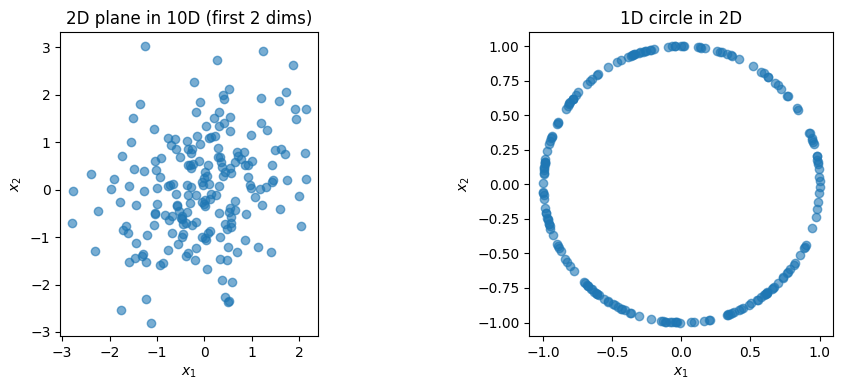

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(plane_data[:, 0].numpy(), plane_data[:, 1].numpy(), alpha=0.6)
axes[0].set_title("2D plane in 10D (first 2 dims)")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].set_aspect("equal")

axes[1].scatter(circle_data[:, 0].numpy(), circle_data[:, 1].numpy(), alpha=0.6)
axes[1].set_title("1D circle in 2D")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

### 1.2 Run all estimators

In [6]:
def run_estimators(data, k="auto"):
    td = TensorDict({"data": data}, batch_size=[])
    results = {}
    timings = {}

    # TwoNN: single scalar per dataset
    t0 = time.perf_counter()
    twonn = TwoNnDimensionEstimator(return_xy=True)
    td_twonn = twonn(td.clone())
    timings["TwoNN"] = time.perf_counter() - t0
    results["TwoNN"] = td_twonn["dimension"].item()
    results["TwoNN_xy"] = (td_twonn["dimension_x"], td_twonn["dimension_y"])

    # Per-point estimators
    for name, est in [
        ("LocalKnn", LocalKnnDimensionEstimator(k=k)),
        ("LocalPCA", LocalPcaDimensionEstimator(k=k)),
        ("CaPca", CaPcaDimensionEstimator(k=k)),
    ]:
        t0 = time.perf_counter()
        td_est = est(td.clone())
        timings[name] = time.perf_counter() - t0
        d = td_est["dimension"]
        valid = torch.isfinite(d)
        results[name] = d[valid].mean().item() if valid.any() else float("nan")
        results[f"{name}_per_point"] = d

    results["timings"] = timings
    print("Timings:", " | ".join(f"{k}: {v:.3f}s" for k, v in timings.items()))
    return results

`k=5`

In [7]:
plane_results = run_estimators(plane_data, k=5)
circle_results = run_estimators(circle_data, k=5)

print("2D plane (expected ~2):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {plane_results[name]:.2f}")

print("\n1D circle (expected ~1):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {circle_results[name]:.2f}")

Timings: TwoNN: 0.017s | LocalKnn: 0.003s | LocalPCA: 1.426s | CaPca: 0.070s
Timings: TwoNN: 0.002s | LocalKnn: 0.001s | LocalPCA: 0.043s | CaPca: 0.058s
2D plane (expected ~2):
  TwoNN: 2.49
  LocalKnn: 2.42
  LocalPCA: 2.00
  CaPca: 1.89

1D circle (expected ~1):
  TwoNN: 1.09
  LocalKnn: 1.18
  LocalPCA: 1.00
  CaPca: 1.00


`k=10`

In [8]:
plane_results = run_estimators(plane_data, k=10)
circle_results = run_estimators(circle_data, k=10)

print("2D plane (expected ~2):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {plane_results[name]:.2f}")

print("\n1D circle (expected ~1):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {circle_results[name]:.2f}")

Timings: TwoNN: 0.002s | LocalKnn: 0.001s | LocalPCA: 0.046s | CaPca: 0.069s
Timings: TwoNN: 0.001s | LocalKnn: 0.001s | LocalPCA: 0.043s | CaPca: 0.055s
2D plane (expected ~2):
  TwoNN: 2.49
  LocalKnn: 2.24
  LocalPCA: 2.00
  CaPca: 1.99

1D circle (expected ~1):
  TwoNN: 1.09
  LocalKnn: 1.05
  LocalPCA: 1.00
  CaPca: 1.00


`k = "auto"`

In [9]:
plane_results = run_estimators(plane_data)
circle_results = run_estimators(circle_data)

print("2D plane (expected ~2):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {plane_results[name]:.2f}")

print("\n1D circle (expected ~1):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {circle_results[name]:.2f}")

Timings: TwoNN: 0.003s | LocalKnn: 0.001s | LocalPCA: 0.045s | CaPca: 0.156s
Timings: TwoNN: 0.002s | LocalKnn: 0.002s | LocalPCA: 0.044s | CaPca: 0.060s
2D plane (expected ~2):
  TwoNN: 2.49
  LocalKnn: 2.18
  LocalPCA: 2.00
  CaPca: 2.00

1D circle (expected ~1):
  TwoNN: 1.09
  LocalKnn: 1.06
  LocalPCA: 1.00
  CaPca: 1.00


### 1.3 TwoNN visualization

TwoNN estimates dimension from the linear relationship $y = d \cdot x$ where $x = \log(\mu)$ and $y = -\log(1-F)$.

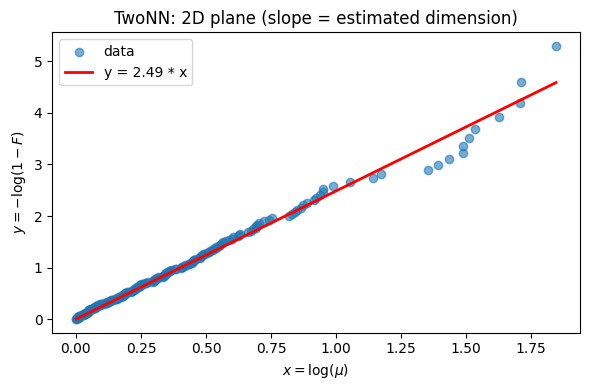

In [10]:
x_plane = plane_results["TwoNN_xy"][0].numpy()
y_plane = plane_results["TwoNN_xy"][1].numpy()
d_plane = plane_results["TwoNN"]
valid = np.isfinite(x_plane) & np.isfinite(y_plane)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x_plane[valid], y_plane[valid], alpha=0.6, label="data")
x_line = np.linspace(x_plane[valid].min(), x_plane[valid].max(), 50)
ax.plot(x_line, d_plane * x_line, "r-", lw=2, label=f"y = {d_plane:.2f} * x")
ax.set_xlabel("$x = \\log(\\mu)$")
ax.set_ylabel("$y = -\\log(1-F)$")
ax.set_title("TwoNN: 2D plane (slope = estimated dimension)")
ax.legend()
plt.tight_layout()
plt.show()

### 1.4 Per-point estimator histograms

Per-point estimators (LocalKnn, LocalPCA, CaPca) give a dimension estimate at each data point. The box plot shows the distribution of these local estimates, revealing variation across the manifold.

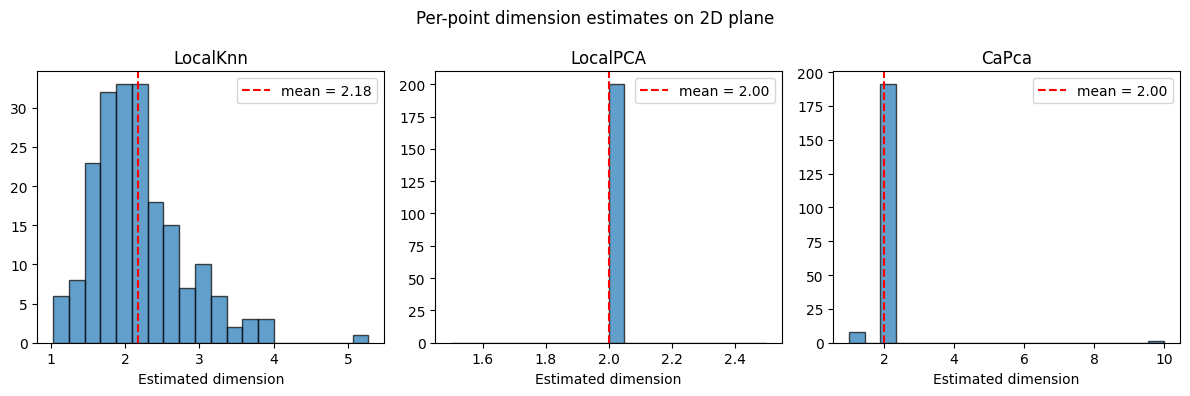

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, name in zip(axes, ["LocalKnn", "LocalPCA", "CaPca"]):
    d = plane_results[f"{name}_per_point"].numpy()
    valid = np.isfinite(d)
    ax.hist(d[valid], bins=20, edgecolor="black", alpha=0.7)
    ax.axvline(plane_results[name], color="red", linestyle="--", label=f"mean = {plane_results[name]:.2f}")
    ax.set_xlabel("Estimated dimension")
    ax.set_title(name)
    ax.legend()

plt.suptitle("Per-point dimension estimates on 2D plane")
plt.tight_layout()
plt.show()

## Part 2: MNIST

We now run the estimators on MNIST digits. The intrinsic dimension of the MNIST manifold is typically around 10-15.

### 2.1 Load MNIST

In [12]:
from datasets import load_dataset

ds = load_dataset("mnist", split="train")
arr = np.array(ds["image"][:1000])
mnist_data = torch.tensor(arr, dtype=torch.float32).reshape(1000, -1) / 255.0


print(f"MNIST shape: {mnist_data.shape}")

MNIST shape: torch.Size([1000, 784])


### 2.2 Sample digits visualization

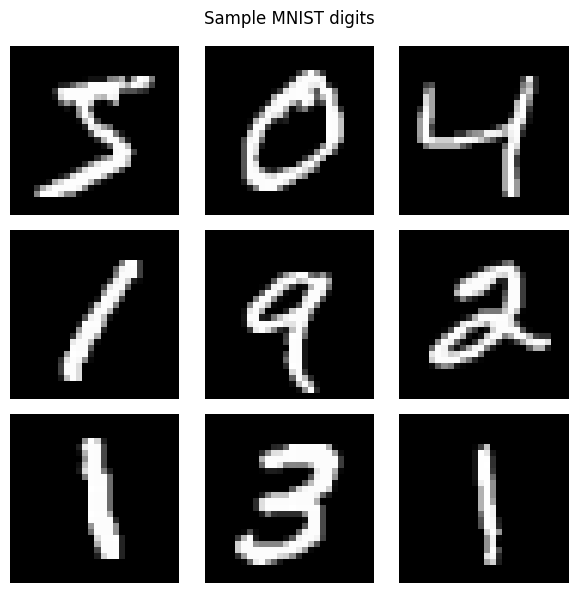

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = mnist_data[i].reshape(28, 28).numpy()
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("Sample MNIST digits")
plt.tight_layout()
plt.show()

### 2.3 Run estimators on MNIST

In [14]:
mnist_results = run_estimators(mnist_data, k="auto")

print("MNIST (expected ~10-15):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {mnist_results[name]:.2f}")

Timings: TwoNN: 0.070s | LocalKnn: 0.033s | LocalPCA: 1.432s | CaPca: 7.581s
MNIST (expected ~10-15):
  TwoNN: 10.13
  LocalKnn: 11.67
  LocalPCA: 31.00
  CaPca: 326.17


### 2.4 TwoNN curve fitting on MNIST

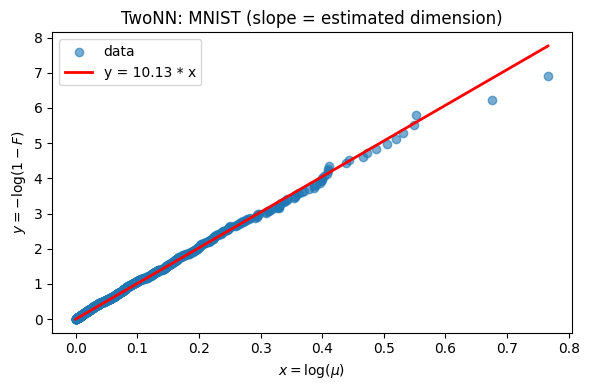

In [15]:
x_mnist = mnist_results["TwoNN_xy"][0].numpy()
y_mnist = mnist_results["TwoNN_xy"][1].numpy()
d_mnist = mnist_results["TwoNN"]
valid = np.isfinite(x_mnist) & np.isfinite(y_mnist)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x_mnist[valid], y_mnist[valid], alpha=0.6, label="data")
x_line = np.linspace(x_mnist[valid].min(), x_mnist[valid].max(), 50)
ax.plot(x_line, d_mnist * x_line, "r-", lw=2, label=f"y = {d_mnist:.2f} * x")
ax.set_xlabel("$x = \\log(\\mu)$")
ax.set_ylabel("$y = -\\log(1-F)$")
ax.set_title("TwoNN: MNIST (slope = estimated dimension)")
ax.legend()
plt.tight_layout()
plt.show()

### 2.5 Box plot: per-point estimators (local variations)

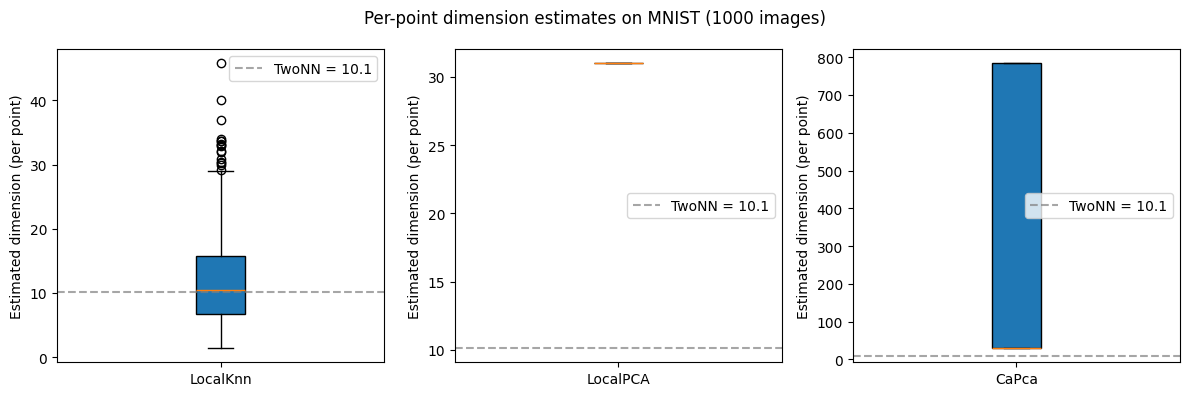

In [16]:
per_point_methods = ["LocalKnn", "LocalPCA", "CaPca"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, name in zip(axes, per_point_methods):
    d = mnist_results[f"{name}_per_point"].numpy()
    d = d[np.isfinite(d)]
    bp = ax.boxplot([d], tick_labels=[name], patch_artist=True)
    ax.axhline(
        mnist_results["TwoNN"], color="gray", linestyle="--", alpha=0.7, label=f"TwoNN = {mnist_results['TwoNN']:.1f}"
    )
    ax.set_ylabel("Estimated dimension (per point)")
    ax.legend()

plt.suptitle("Per-point dimension estimates on MNIST (1000 images)")
plt.tight_layout()
plt.show()

### 2.6 Using 5000 images

In [17]:
arr = np.array(ds["image"][:5000])
mnist_data_5k = torch.tensor(arr, dtype=torch.float32).reshape(5000, -1) / 255.0

mnist_results_5k = run_estimators(mnist_data_5k, k="auto")

print("MNIST (5000 images, expected ~10-15):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {mnist_results_5k[name]:.2f}")

Timings: TwoNN: 0.573s | LocalKnn: 0.531s | LocalPCA: 19.411s | CaPca: 48.642s
MNIST (5000 images, expected ~10-15):
  TwoNN: 12.35
  LocalKnn: 12.33
  LocalPCA: 70.00
  CaPca: 308.19


In [18]:
print("Comparison (1000 vs 5000 images):")
for name in ["TwoNN", "LocalKnn", "LocalPCA", "CaPca"]:
    print(f"  {name}: {mnist_results[name]:.2f} (1k) → {mnist_results_5k[name]:.2f} (5k)")

Comparison (1000 vs 5000 images):
  TwoNN: 10.13 (1k) → 12.35 (5k)
  LocalKnn: 11.67 (1k) → 12.33 (5k)
  LocalPCA: 31.00 (1k) → 70.00 (5k)
  CaPca: 326.17 (1k) → 308.19 (5k)


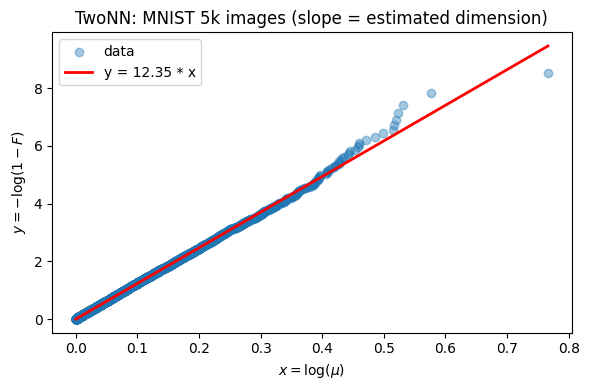

In [19]:
x_mnist_5k = mnist_results_5k["TwoNN_xy"][0].numpy()
y_mnist_5k = mnist_results_5k["TwoNN_xy"][1].numpy()
d_mnist_5k = mnist_results_5k["TwoNN"]
valid = np.isfinite(x_mnist_5k) & np.isfinite(y_mnist_5k)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x_mnist_5k[valid], y_mnist_5k[valid], alpha=0.4, label="data")
x_line = np.linspace(x_mnist_5k[valid].min(), x_mnist_5k[valid].max(), 50)
ax.plot(x_line, d_mnist_5k * x_line, "r-", lw=2, label=f"y = {d_mnist_5k:.2f} * x")
ax.set_xlabel("$x = \\log(\\mu)$")
ax.set_ylabel("$y = -\\log(1-F)$")
ax.set_title("TwoNN: MNIST 5k images (slope = estimated dimension)")
ax.legend()
plt.tight_layout()
plt.show()

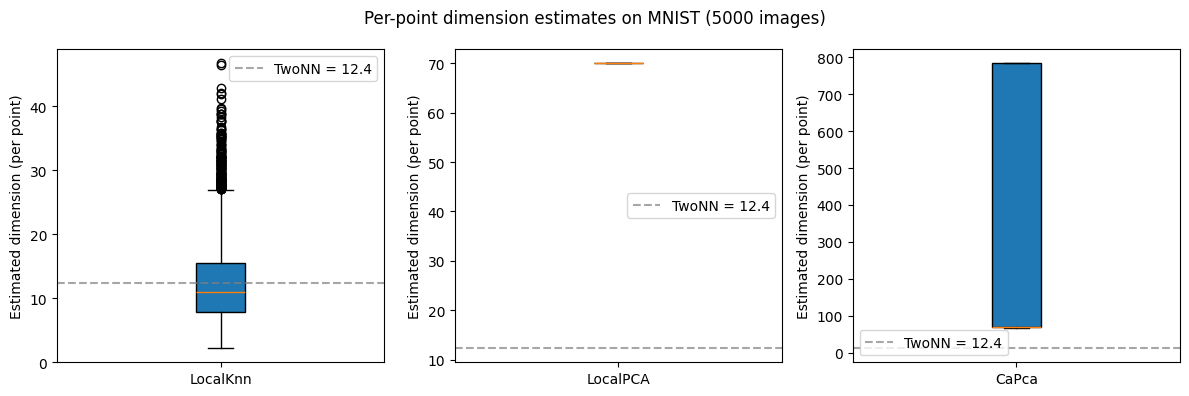

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, name in zip(axes, per_point_methods):
    d = mnist_results_5k[f"{name}_per_point"].numpy()
    d = d[np.isfinite(d)]
    bp = ax.boxplot([d], tick_labels=[name], patch_artist=True)
    ax.axhline(
        mnist_results_5k["TwoNN"],
        color="gray",
        linestyle="--",
        alpha=0.7,
        label=f"TwoNN = {mnist_results_5k['TwoNN']:.1f}",
    )
    ax.set_ylabel("Estimated dimension (per point)")
    ax.legend()

plt.suptitle("Per-point dimension estimates on MNIST (5000 images)")
plt.tight_layout()
plt.show()

### 2.7 Per-label dimension estimation

In [21]:
labels = np.array(ds["label"][:5000])
per_label = {}
for d in range(10):
    subset = mnist_data_5k[labels == d]
    per_label[d] = run_estimators(subset, k="auto")

print("Per-label dimension estimates (5000 images):")
for d in range(10):
    r = per_label[d]
    print(
        f"  {d}: TwoNN={r['TwoNN']:.2f} LocalKnn={r['LocalKnn']:.2f} LocalPCA={r['LocalPCA']:.2f} CaPca={r['CaPca']:.2f} (n={(labels == d).sum()})"
    )

Timings: TwoNN: 0.006s | LocalKnn: 0.006s | LocalPCA: 0.395s | CaPca: 3.138s
Timings: TwoNN: 0.007s | LocalKnn: 0.006s | LocalPCA: 0.426s | CaPca: 3.824s
Timings: TwoNN: 0.005s | LocalKnn: 0.005s | LocalPCA: 0.376s | CaPca: 3.373s
Timings: TwoNN: 0.005s | LocalKnn: 0.005s | LocalPCA: 0.378s | CaPca: 3.273s
Timings: TwoNN: 0.006s | LocalKnn: 0.005s | LocalPCA: 0.461s | CaPca: 3.542s
Timings: TwoNN: 0.004s | LocalKnn: 0.004s | LocalPCA: 0.295s | CaPca: 2.797s
Timings: TwoNN: 0.006s | LocalKnn: 0.005s | LocalPCA: 0.373s | CaPca: 3.303s
Timings: TwoNN: 0.006s | LocalKnn: 0.006s | LocalPCA: 0.429s | CaPca: 3.616s
Timings: TwoNN: 0.007s | LocalKnn: 0.005s | LocalPCA: 0.333s | CaPca: 3.048s
Timings: TwoNN: 0.005s | LocalKnn: 0.005s | LocalPCA: 0.381s | CaPca: 3.259s
Per-label dimension estimates (5000 images):
  0: TwoNN=12.46 LocalKnn=9.44 LocalPCA=21.00 CaPca=140.47 (n=479)
  1: TwoNN=10.27 LocalKnn=6.98 LocalPCA=23.00 CaPca=296.04 (n=563)
  2: TwoNN=12.00 LocalKnn=12.26 LocalPCA=22.00 CaPc